# Decision Tree



#### Methods:
- build
- predict
- accuracy
- classification_report(precision, recall, f1) + visualization
- feature_importances + visualization
- get_depth
- get_n_leaves
- print_tree

#### Hyperparameters:
- max_depth
- min_samples_split


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### decision_tree.py

In [2]:
class DecisionTree:
    """A decision tree for classification based on the CART algorithm.

    Args:
        max_depth (int or None, default=None): The maximum depth of the tree. Used to control over-fitting.
        min_samples_split (int, default=2): The minimum samples for splitting a node. Used to control over-fitting.

    Attributes:
        tree (Node object): The root node of the decision tree.
        classes (ndarray): The class labels.
    """
    def __init__(self, max_depth=None, min_samples_split=2):
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self.tree = None
        self.classes = None
        self._feature_importances = None
        self._n_samples = None
        self._node_id = -1

    def build(self, x, y):
        """Builds a decision tree based on the training set (x, y).

        Args:
            x (array-like, shape = [n_samples, n_features]): The training samples. Values must be numeric.
            y (array-like, shape = [n_samples]): The class labels of samples in x. Values can be integers or strings.
        """
        x, y = np.copy(x), np.copy(y)
        self.classes = np.unique(y)
        self._feature_importances = np.zeros((x.shape[1]))
        self._n_samples = x.shape[0]
        self.tree = self._build(x, y)

    def _build(self, x, y, depth=0):
        """Recursively builds a decision tree.

        Args:
            x (array-like, shape = [n_samples, n_features]): The training samples.
            y (array-like, shape = [n_samples]): The class labels of samples in x.
            depth (int): The depth of the tree.

        Returns:
            Node object: The root node of the tree.
        """
        # the current node
        class_counts = [np.sum(y == k) for k in self.classes]
        class_prediction = self.classes[np.argmax(class_counts)]
        self._node_id += 1
        node = Node(self._node_id, gini(y), x.shape[0], class_counts, class_prediction)

        # if maximum depth has been reached stop expanding
        if not (self._max_depth and depth >= self._max_depth):
            feature, threshold = best_split(x, y, self._min_samples_split)
            # feature, threshold will be None if the node cannot be split
            if feature is not None:
                node.feature, node.threshold = feature, threshold
                # the left node will get the samples with feature values <= threshold of the split
                # and the right node the rest
                permutation_left = np.nonzero(x[:, feature] <= threshold)
                permutation_right = np.nonzero(x[:, feature] > threshold)
                node.left = self._build(x[permutation_left], y[permutation_left], depth + 1)
                node.right = self._build(x[permutation_right], y[permutation_right], depth + 1)
        return node

    def predict(self, x):
        """Predicts the class of every sample in x.

        Args:
            x (array-like, shape = [n_samples, n_features]): The input samples. Values must be numeric.

        Returns:
            ndarray of shape = [n_samples]: The class predictions of samples in x.
        """
        x = np.copy(x)
        predictions = x.shape[0]*[0]
        for i, sample in enumerate(x):
            node = self.tree
            while node.left:
                node = node.left if sample[node.feature] <= node.threshold else node.right
            predictions[i] = node.class_prediction
        return np.array(predictions)

    def accuracy(self, x, y):
        """Calculates the mean accuracy on the test set (x, y).

        Args:
            x (array-like, shape = [n_samples, n_features]): The test samples. Values must be numeric.
            y (array-like, shape = [n_samples]): The test class labels. Values can be integers or strings.

        Returns:
            float: The mean accuracy.
        """
        predictions = self.predict(x)
        return np.mean(predictions == y)

    def classification_report(self, x, y, plot=False, cmap='YlOrRd'):
        """The classification report consists of the precision, the recall and the F1 scores. It returns a dictionary
        with the scores and will also display a heatmap if the argument plot is set to True.

        Args:
            x (array-like, shape = [n_samples, n_features]): The test samples. Values must be numeric.
            y (array-like, shape = [n_samples]): The test class labels. Values can be integers or strings.
            plot (bool, default=False): If true, displays heatmap.
            cmap (string, default='YlOrRd'): The name of the colormap to be used for the heatmap if plot=True.

        Returns:
            dict: A dictionary that contains the precision, recall and F1 scores for each class.
        """
        y = np.copy(y)
        predictions = self.predict(x)
        report = {}
        for c in self.classes:
            tp = sum(np.sum(predictions[i] == c and y[i] == c) for i in range(y.shape[0]))
            precision = tp / np.sum(predictions == c)
            recall = tp / np.sum(y == c)
            f1_score = 2*precision*recall / (precision + recall)
            report[c] = {'precision': precision, 'recall': recall, 'f1': f1_score}
        if plot:
            visualize_classification_report(report, self.classes, cmap)
        return report

    def feature_importances(self, plot=False, feature_names=None, color='steelblue'):
        """Returns the feature importances. If the argument plot is set to true it will also display them in a plot.

        The feature importance is computed as the normalized total reduction of node gini impurity weighted by the
        probability of reaching that node.

        Args:
            plot (bool, default=False): If true, displays the feature importances in a plot.
            feature_names (array-like, shape = [n_features]): The feature names. Used for the plot.
            color (string, default='steelblue'): The color to use for the plot.

        Returns:
            ndarray of shape = [n_features]: The feature importances.
        """
        self._calc_feature_importances(self.tree)
        # normalize feature importances to be summed to 1
        self._feature_importances = self._feature_importances / np.sum(self._feature_importances)
        if plot:
            visualize_feature_importances(self._feature_importances, feature_names, color)
        return self._feature_importances

    def _calc_feature_importances(self, node):
        """Calculates the feature importances.

        Args:
            node (Node object): The current node. The initial node is the root of the tree.
        """
        if node.left:
            node_importance = node.samples / self._n_samples * node.gini - \
                              node.left.samples / self._n_samples * node.left.gini - \
                              node.right.samples / self._n_samples * node.right.gini
            self._feature_importances[node.feature] += node_importance

            self._calc_feature_importances(node.left)
            self._calc_feature_importances(node.right)

    def get_depth(self):
        """Returns the depth of the decision tree.
        """
        return self._get_depth(self.tree)

    def _get_depth(self, node, current_depth=0, depth=0):
        """Recursively finds the depth of the decision tree.

        Args:
            node (Node object): The current node. The initial node is the root of the tree.
            current_depth (int): The depth of the current node.
            depth (int): The maximum depth found.
        """
        if depth < current_depth:
            depth = current_depth
        if node.left:
            depth = self._get_depth(node.left, current_depth + 1, depth)
            depth = self._get_depth(node.right, current_depth + 1, depth)
        return depth

    def get_n_leaves(self):
        """Returns the number of leaves of the decision tree.
        """
        return self._get_n_leaves(self.tree)

    def _get_n_leaves(self, node, leaves=0):
        """Recursively finds the number of leaves of the decision tree.

        Args:
            node (Node object): The current node. The initial node is the root of the tree.
            leaves (int): The number of leaves.
        """
        if node.left is None:
            leaves += 1
        else:
            leaves = self._get_n_leaves(node.left, leaves)
            leaves = self._get_n_leaves(node.right, leaves)
        return leaves

    def print_tree(self, max_depth=None):
        """Prints the information of the tree's nodes.

        Args:
            max_depth (int or None, default=None): The max depth to print.
        """
        self._print_tree(self.tree, max_depth)

    def _print_tree(self, node, max_depth, depth=0):
        """Recursively prints the information of the tree's nodes.

        Args:
            node (Node object): The current node. The initial node is the root of the tree.
            max_depth (int or None): The max depth to print.
            depth (int): The current depth.
        """
        if max_depth and depth > max_depth:
            return
        print("Depth:", depth)
        if node.left is None:
            print("node #" + str(node.node_id), "| gini =", "%.3f" % round(node.gini, 3), "| samples =", node.samples,
                  "| value =", node.class_counts, "| class =", node.class_prediction)
        else:
            print("node #" + str(node.node_id), "| X" + str(node.feature), "<=", node.threshold,
                  "| gini =", "%.3f" % round(node.gini, 3), "| samples =", node.samples, "| value =", node.class_counts,
                  "| class =", node.class_prediction)
            self._print_tree(node.left, max_depth, depth + 1)
            self._print_tree(node.right, max_depth, depth + 1)

### node.py

In [3]:
class Node:
    """Tree node representation.

    Args:
        node_id (int): The unique id of the node.
        gini (float): The gini impurity of the node.
        samples (int): The number of samples of the node.
        class_counts (array, shape[n_classes]): The number of samples corresponding to each class.
        class_prediction (int or string): The predicted class of the node, which is the class with the most samples.
        feature (int): The feature index of the split.
        threshold (float): The threshold value of the split.
        left (Node object): The left child of the node.
        right (Node object): The right child of the node.
    """
    def __init__(self, node_id, gini, samples, class_counts, class_prediction, feature=None, threshold=None, left=None,
                 right=None):
        self.node_id = node_id
        self.gini = gini
        self.samples = samples
        self.class_counts = class_counts
        self.class_prediction = class_prediction
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

### splitter.py

In [4]:
def gini(y):
    """Calculates the gini impurity of a node.

    Args:
        y (array-like, shape[n_samples]): The class labels of a node's samples.

    Returns:
        float: The gini impurity.
    """
    classes, counts = np.unique(y, return_counts=True)
    return 1 - np.sum((counts / y.shape[0]) ** 2)


def best_split(x, y, min_samples_split):
    """Finds the best split point of a node.

    Checks all the possible split points for every feature and returns the feature index and threshold value of the
    split that minimizes the gini impurity.

    Args:
        x (array-like, shape = [n_samples, n_features]): The node's samples.
        y (array-like, shape = [n_samples]): The node's class labels.
        min_samples_split (int): The minimum samples a node must have to consider splitting it.

    Returns:
        best_feature (int): The feature index of the best split.
        best_threshold (float): The threshold value of the best split.
    """
    n = y.shape[0]
    best_feature, best_threshold = None, None
    best_gini = gini(y)

    # stop splitting if the node has less than the minimum samples or if all the samples belong to the same class
    if n < min_samples_split or best_gini == 0:
        return best_feature, best_threshold

    for feature in range(x.shape[1]):
        permutation = x[:, feature].argsort()
        x_sorted, y_sorted = x[permutation], y[permutation]

        # can't split between same values so skip
        for i in range(1, n):
            if x_sorted[i, feature] == x_sorted[i - 1, feature]:
                continue

            # check if the split impurity is minimum
            gini_split = (i * gini(y_sorted[:i]) + (n - i) * gini(y_sorted[i:])) / n
            if gini_split < best_gini:
                best_gini = gini_split
                best_feature = feature
                best_threshold = (x_sorted[i, feature] + x_sorted[i - 1, feature]) / 2
    return best_feature, best_threshold

### visualizer.py

In [5]:
def visualize_classification_report(report, classes, cmap):
    """Creates a heatmap for the precision, recall and f1 scores of the classes.

    Args:
        report (dict): A dictionary with the precision, recall and f1 scores of each class.
        classes (array): The class labels.
        cmap: (string): The name of the colormap to be used for the heatmap.
    """
    values = np.array([[report[c]['precision'], report[c]['recall'], report[c]['f1']] for c in report])

    # create the heatmap
    fig, ax = plt.subplots()
    pcolor = ax.pcolor(values, edgecolors='white', linewidths=0.8, cmap=cmap, vmin=0, vmax=1)
    ax.set_xticks(np.arange(values.shape[1]) + 0.5)
    ax.set_yticks(np.arange(values.shape[0]) + 0.5)
    ax.set_xticklabels(['Precision', 'Recall', 'F1'])
    ax.set_yticklabels(classes)

    # add values to the heatmap
    pcolor.update_scalarmappable()
    for path, color, value in zip(pcolor.get_paths(), pcolor.get_facecolors(), pcolor.get_array()):
        x, y = path.vertices[:-2, :].mean(0)
        # set text color according to background color for better visibility
        color = (0.0, 0.0, 0.0) if np.all(color[:3] > 0.5) else (1.0, 1.0, 1.0)
        ax.text(x, y, "%.3f" % value, ha="center", va="center", color=color)

    cbar = plt.colorbar(pcolor, values=np.arange(0.0, 1.1, 0.1))
    cbar.outline.set_edgecolor('lightgray')
    cbar.outline.set_linewidth(1.2)
    plt.setp(ax.spines.values(), color='silver')
    plt.title("Classification Report")


def visualize_feature_importances(feature_importances, feature_names, color):
    """Creates a bar chart for the feature importances.

    Args:
        feature_importances (array-like, shape = [n_features]): The feature importances.
        feature_names (array-like, shape = [n_features]): The feature names.
        color (string): The color of the bars.
    """
    n_features = feature_importances.shape[0]
    sorted_indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    plt.barh(range(n_features), feature_importances[sorted_indices], color=color)
    if feature_names is None:
        plt.yticks(range(n_features), sorted_indices)
    else:
        plt.yticks(range(n_features), feature_names)

    ax.xaxis.grid(color='lightgray')
    ax.set_axisbelow(True)
    plt.setp(ax.spines.values(), color='lightgray')
    plt.title("Feature Importances")

## Test decision tree

### Load Data

Car evaluation dataset: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In [6]:
def get_data(path):
    
    # load data
    car_data = pd.read_csv(path)
    y = car_data.iloc[:, -1]
    feature_names = ['buying', 'maint', 'doors', 'persons', 'lug_boots', 'safety']
    class_names = y.unique()

    # label encoding
    le = preprocessing.LabelEncoder()
    for i in range(len(car_data.columns) - 1):
        car_data.iloc[:, i] = le.fit_transform(car_data.iloc[:, i])
    x = car_data.iloc[:, :-1]
    
    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

    return x_train, x_test, y_train, y_test, class_names, feature_names


Time: 0.07181930541992188
Accuracy: 0.976878612716763
Depth: 13
Leaves: 88
Precision, recall, f1: {'acc': {'precision': 0.96, 'recall': 0.935064935064935, 'f1': 0.9473684210526316}, 'good': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1': 0.9655172413793104}, 'unacc': {'precision': 0.9876543209876543, 'recall': 0.9917355371900827, 'f1': 0.9896907216494846}, 'vgood': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1': 0.9230769230769231}}
Feature importances: [0.14445402 0.24472048 0.05346573 0.19588359 0.11164789 0.24982828]
First 2 layers of the tree:
Depth: 0
node #0 | X3 <= 0.5 | gini = 0.457 | samples = 1381 | value = [307, 55, 967, 52] | class = unacc
Depth: 1
node #1 | gini = 0.000 | samples = 463 | value = [0, 0, 463, 0] | class = unacc
Depth: 1
node #2 | X5 <= 0.5 | gini = 0.580 | samples = 918 | value = [307, 55, 504, 52] | class = unacc
Depth: 2
node #3 | X0 <= 2.5 | gini = 0.626 | samples = 313 | value = [170, 24, 67, 52] | class = acc
Depth: 2
node #

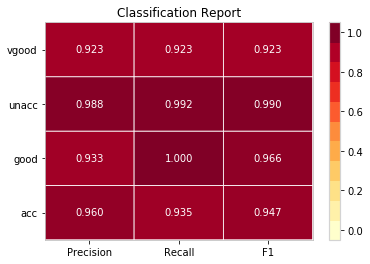

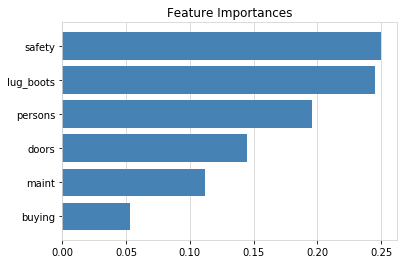

In [8]:
X_train, X_test, y_train, y_test, class_names, feature_names = get_data('data/car_evaluation.csv')

start = time.time()
dt = DecisionTree(max_depth=None, min_samples_split=2)
dt.build(X_train, y_train)
end = time.time()

prediction = dt.predict(X_test)
accuracy = dt.accuracy(X_test, y_test)
report = dt.classification_report(X_test, y_test, plot=True)
depth = dt.get_depth()
leaves = dt.get_n_leaves()
feature_importances = dt.feature_importances(plot=True, feature_names=feature_names)
print('Time:', end - start)
print('Accuracy:', accuracy)
print('Depth:', depth)
print('Leaves:', leaves)
print('Precision, recall, f1:', report)
print('Feature importances:', feature_importances)
print('First 2 layers of the tree:')
dt.print_tree(max_depth=2)
plt.show()